# A multinomial model for text

Dante’s “Divina Commedia” is a well known example of a poem in which the author uses different styles
through the different parts of the work. The poem is divided in three Cantiche, respectively “Inferno”
(Hell), “Purgatorio” (Purgatory) and “Paradiso” (Heaven). Each part is written using different linguistic
styles, moving from less to more aulic as we progress from Hell towards Heaven. Each Cantica is divided
in Canti, 34 for Inferno, and 33 for Purgatorio and Paradiso. Each Canto consists of a variable number
of verses (115 to 160), organized in tercets. <br>
In this laboratory we will use statistical methods to analyze how the stylistic differences can be exploited
to understand the Cantica of a given tercet. In particular, we will build a multinomial word model for
the three Canticas and classify tercets excerpts. To avoid biased results, the tercets used to train the
model will be different from those we evaluate on.


### Loading Data
The files data/inferno.txt, data/purgatorio.txt, data/paradiso.txt contain tercets for the
three different parts. To simplifying parsing, the files are already organized so that each line corresponds
to a tercet. We use $25%$ of the tercets as validation, and the remaining ones as
training data.

In [19]:
import numpy as np
from load import load_data, split_data

In [9]:
lInf, lPur, lPar = load_data()
print("lInf - size (number of tercets):", len(lInf))
print("lPur - size (number of tercets):", len(lPur))
print("lPar - size (number of tercets):", len(lPar)) 

lInf - size (number of tercets): 1597
lPur - size (number of tercets): 1608
lPar - size (number of tercets): 1607


In [10]:
#Split the data: reserve 25% for validation, 75% for training
lInf_train, lInf_evaluation = split_data(lInf, 4)
lPur_train, lPur_evaluation = split_data(lPur, 4)
lPar_train, lPar_evaluation = split_data(lPar, 4)

print("lInf_train - size (number of tercets):", len(lInf_train))
print("lInf_evaluation - size (number of tercets):", len(lInf_evaluation))
print("lPur_train - size (number of tercets):", len(lPur_train))
print("lPur_evaluation - size (number of tercets):", len(lPur_evaluation))
print("lPar_train - size (number of tercets):", len(lPar_train))
print("lPar_evaluation - size (number of tercets):", len(lPar_evaluation))

lInf_train - size (number of tercets): 1197
lInf_evaluation - size (number of tercets): 400
lPur_train - size (number of tercets): 1206
lPur_evaluation - size (number of tercets): 402
lPar_train - size (number of tercets): 1205
lPar_evaluation - size (number of tercets): 402


Now, we create a dictionary of all te tercets used for training:

In [11]:
DTR = {
    "lInf": lInf_train,
    "lPur": lPur_train,
    "lPar": lPar_train
}

In [104]:
print(f"Number of Inferno tercets: {len(lInf_evaluation)}")
print(f"Number of Purgatorio tercets: {len(lPur_evaluation)}")
print(f"Number of Paradiso tercets: {len(lPar_evaluation)}")

Number of Inferno tercets: 400
Number of Purgatorio tercets: 402
Number of Paradiso tercets: 402


In [35]:
DVAL = lInf_evaluation + lPur_evaluation + lPar_evaluation

We build the true labels for each tercet, since we know that the first $400$ tercets belong to *Inferno*, the next $402$ to *Purgatorio* and the last $402$ to *Paradiso*:

In [109]:
LVAL = [0] * len(lInf_evaluation) + [1] * len(lPur_evaluation) + [2] * len(lPar_evaluation)
LVAL = np.array(LVAL)
print(f"LVAL has shape: {LVAL.shape}")

LVAL has shape: (1204,)


## Model #1
We can assume the document is composed of $N$ words (for ex: if the document is just a simple sentence like "How are you", we have $N = 3$). <br>
More precisely, each word corresponds to a **token**: in the *NLP* field, a token is a single unit of text, and in the simplest case, the one considered here, a token is a word. <br>
Moreover, we can abstract and consider that we have $N$ Random Variables $X_0, X_1, X_2, ... , X_n \in D$ that describe the $N$ tokens of the document. $D$ is the *set* of all the possible *distinct* words in the document, has size equal to $M$, and is called *dictionary*: if for example the document is "How are you, you are good", $D$ contains just {"How", "are", "you", "good"} and $M = 4$. <br>
Having said that, we can consider the whole document to be the realization (i.e. observation) of the $N$ R.V. $(X_1, ..., X_n)$. <br>
We also consider all the tokens to be *i.i.d.*, so, for any pair of tokens $X_p$ and $X_z$, we have:
$$
P(X_p, X_z) = P(X_p) \cdot P(X_z) \quad \text{for } p \neq z
$$

We can model everything in terms of a **Categorical Distribution**: <br>
Each $X_i$ (for $i = 1, \ldots, N$) is a categorical random variable that takes values in the dictionary $D = \{D_1, D_2, \ldots, D_M\}$ with probability:

$$
P(X_i = D_j) = \pi_j \quad \text{for } j = 1, \ldots, M
$$

where:

- $\pi_j$ is the probability of observing the $j$-th word from the dictionary,
- $\pi_j \geq 0$ for all $j$,
- and $\sum_{j=1}^{M} \pi_j = 1$.

The whole document can be seen as a sequence of $N$ independent draws from this categorical distribution. 

### Parameters estimation via Maximum Likelihood approach
$\Pi = (\pi_1, \pi_2, ..., \pi_M)$ are the model parameters that we have to estimate in order to compute the likelihoods. <br>
Recalling the **Categorical Distribution** formulas, we can say that each token $X_i$ is a categorical random variable with probability mass function:

$$
f_{X_i}(x) = P(X_i = x) = \prod_{j=1}^{M} \pi_j^{\mathbb{I}[x = D_j]}
$$

where:

- $\pi_j$ is the probability of word $D_j$ in the dictionary,
- $\mathbb{I}[x = D_j]$ is the indicator function that is $1$ if $x = D_j$ and $0$ otherwise.

If, for example, we have a document having Tokens: ["dog", "cat", "dog", "cat", "dog"] and dictionary $D$ = {dog, cat} (so, $N =5$, $M=2$), we would compute the following probability mass functions:
$$
f_{X_1}(\text{"dog"}) = \pi_{"dog"}^1 \times \pi_{"cat"}^0 = \pi_{"dog"}\\
f_{X_2}(\text{"cat"}) = \pi_{"dog"}^0 \times \pi_{"cat"}^1 = \pi_{"cat"}
$$

As a result, we can then compute the **Likelihood function** as the product of all the probability mass functions for each one of the $N$ independent tokens in the document:
$$
\mathcal{L}_X \left( \Pi \right) = \mathcal{L}_X(\pi_1, \pi_2, \dots, \pi_M) = P(X_1, X_2, \dots, X_N) = \prod_{i=1}^{N} \prod_{j=1}^{M} \pi_j^{\mathbb{I}[X_i = D_j]}
$$
Where:

- $\pi_j$ is the probability of observing the $j$-th word in the dictionary $D$,
- $\mathbb{I}[X_i = D_j]$ is the indicator function that is 1 if $X_i = D_j$ and 0 otherwise.

The first product runs over all tokens $X_1, X_2, \dots, X_N$, and the second product runs over all possible words in the dictionary $D_1, D_2, \dots, D_M$. <br>
Shifting to the *log-domain*, we can write:
$$
\ell_X(\Pi) = \log \mathcal{L}_X(\Pi) = \sum_{i=1}^{N} \sum_{j=1}^{M} \mathbb{I}[x_i = j] \log \pi_j = \sum_{j=1}^{M} N_j \log \pi_j
$$
Where:
- $\mathbb{I}[x_i = j]$ is the indicator function (1 if $x_i = j$, 0 otherwise),
- $N_j$ is the number of times word $j$ appears in the document.

We have the constraint that the probabilities must sum to 1:

$$
\sum_{j=1}^{M} \pi_j = 1
$$

To solve the **Maximum Likelihood Estimation (MLE)** problem under this constraint, we use the **method of Lagrange multipliers**.

We define the **Lagrangian function** $\ell_X(\Pi, \lambda)$ to include this contraint when maximizing the log-likelihood:

$$
\ell_X(\Pi, \lambda) = \ell_X(\pi_1, \dots, \pi_M, \lambda) = \sum_{j=1}^{M} N_j \log \pi_j + \lambda \left(1 - \sum_{j=1}^{M} \pi_j \right)
$$

Then, we compute the partial derivatives and set them to zero:

For each $j = 1, \dots, M$:

$$
\frac{\partial \ell}_X{\partial \pi_j} = \frac{N_j}{\pi_j} - \lambda = 0
$$

And for the constraint:

$$
\frac{\partial \ell}_X{\partial \lambda} = 1 - \sum_{j=1}^{M} \pi_j = 0
$$

Solving this system gives us the MLE estimates for $\pi_j$. <br>
The ML estimates of the model parameters can be obtained by maximizing the log-likelihood function for each *cantica* $c$:
the ML estimate of the probability of word $j$ in cantica $c$ is given by:
$$
\pi_{c,j} = \frac{N_{c,j}}{N_c}
$$
Where:
- $N_{c,j}$ is the number of occurrences of each word $j$ (belonging to $D$) in cantica $c$, 
- $N_c = \sum_{j=1}^{M} N_{c,j}$ is the total number of tokens in cantica $c$.

This means that:

> The ML estimate $\pi_{c,j}$ is simply the **relative frequency** of word $j$ in cantica $c$.

> This is a fundamental result: under the assumption that words are *i.i.d.* samples from a categorical distribution, the MLE of each word's probability is **just the proportion of times the word appears in the document**. <br>

So, the complete formula in the log-domain for the likelihood is:
$$
\ell_X(\Pi) = \log \ell_X(\Pi) = \sum_{i=1}^{N} \sum_{j=1}^{M} \mathbb{I}[x_i = j] \log \pi_j = \sum_{j=1}^{M} N_j \log \pi_j = \sum_{j=1}^{M} N_j \left[ \log N_{c,j} - \log N_c \right]
$$

**NOTE**: for some classes word frequencies may be 0. Since the prediction is based on the logarithm of
the frequencies, this implies that we will get $- \infty $ values for samples that contain words that do not
appear in one cantica, corresponding to a class-conditional probability (likelihood) of 0. This may lead
to numerical issues, since we may have prediction likelihoods for different canticas that are 0 for all three
classes (e.g., a tercet containg a word that does not appear in Inferno, a second word that does not
appear in Purgatory and a third word that does not appear in Paradiso). <br>
A solution is to introduce augmented counts, so instead of using $N_{c,j}$ we use its *smoothed* version:
$$
N_{bc,j} = N_{c,j} + \varepsilon
$$
Where $\varepsilon$ is a small positive value and it's considered an hyperparameter. <br>
So the smoothed formula for the log-likelihood, the one that will be used in the code, is this:
$$
\ell_X(\Pi) \approx \ell_X (\Pi, \varepsilon) = \sum_{j=1}^{M} N_j \left[ \log \left( N_{c,j} + \varepsilon \right) - \log N_c \right]
$$

To compute the frequencies we first need to build the dictionary of all possible words. We consider only
words that appear in the training set — if test or validation tercets contain unknown words we can
simply discard them, as they would not, in any case, provide support for any of the three hypotheses
under consideration. <br>
The best way to do this is using a dictionary where the keys are the distinct words, and the values are occurrences of each word in the cantica:

In [13]:
def Model1_buildDict(canticaTercets):
    """
    This function builds a dictionary of words from the cantica tercets.
    It returns a set of words.

    Parameters:
    canticaTercets (list): A list of tercets from a cantica.

    Returns:
    Dc: A dictionary of words with their frequencies.
    Nc: the number of all the tokens (i.e. the sum of appearances of each word) appearing in the canticaTercets
    """

    Dc = {}
    Nc = 0

    for tercet in canticaTercets:
        words = tercet.split()
        for word in words:
            Nc += 1
            if (word not in Dc.keys()):
                Dc[word] = 1
            else:
                Dc[word] += 1


    return Dc, Nc

To compute the model estimators using the *ML* approach, let's call with function which returns a dictionary where, for each cantica c, it contains another dictionary storing the relative frequency in the cantica for each word:

In [52]:
def Model1_Estimators(DTR, eps = 0.001):
    """
    This function computes, for each cantica, a dictionary storing the relative frequency for each word in the cantica, corresponding to the MLE.

    Parameters:
    - DTR: A dictionary of key=canticaLabel, value=list of tercets in the cantica
    - eps: epsilon, so the value in order to smooth frequencies

    Returned Values:
    - MLE: log Maximum Likelihood Estimators for each word in each cantica c: keys: cantica labels, values: list where index i is the SMOOTHED log frequency of word i of cantica c
    """


    MLE = {}

    globalDict = set() #global dict computed as the union between the cantica dicts keys sets
    canticaTokenCounts = {} #dictionary storing each Nc (token count) for each cantica c
    canticaDicts = {}  #dictionary storing canticaDict foe each cantica

    #For each cantica c
    #1. Build a dictionary of key: word, value: #times the word appears in the cantica c
    #2. Find Nc which is the number of all tokens (i.e. the sum of appearances of each word) appearing in the canticaTercets
    #3. The MLE are found by calculating the frequency of each word in the cantica c

    #1-2. Dictionary building, Nc for each cantica
    for canticaLabel in DTR.keys():
        # canticaLabel can be lInf, lPur, lPar

        canticaDict, Nc = Model1_buildDict(DTR[canticaLabel])
        globalDict = globalDict.union(canticaDict.keys())
        canticaTokenCounts[canticaLabel] = Nc
        canticaDicts[canticaLabel] = canticaDict




    #3. Compute smoothed MLE
    #Smoothing: in order to not have frequency = zero for a certain word, set all the frequencies to eps, so augment the word count with pseudo-count
    for canticaLabel in DTR.keys(): 
        MLE[canticaLabel] = {}
        canticaDict = canticaDicts[canticaLabel]
        Nc = canticaTokenCounts[canticaLabel]

        for word in globalDict:
            #if the word of the globalDict appears also in the canticaDict -> frequency is log{(Nc,j + eps) / Nc}
            #otherwise, frequency is log{(0 + eps) / Nc} = log{eps / Nc}

            #use dict.get(word, defaultNone) in order to return Nc,j = 0 if the word is NOT present in the canticaDict
            #simply using canticaDict[word] would raise an exception in this case

            N_cj = canticaDict.get(word, 0)

            MLE[canticaLabel][word] = np.log(N_cj + eps) - np.log(Nc)




    return MLE, globalDict


Here are the MLE:

In [53]:
MLE, globalDict = Model1_Estimators(DTR)

### Predicting the cantica
We now turn to prediction for a given tercet $t$. Again, we can represent the tercet in terms of its tokens
$x = [x_1, x_2, ..., x_N ]$ (here $N$ refers to the length of the validation tercet, and $x_i$
is the $i$-th word of the tercet). <br>
As said before, the likelihood of a word $x$ is expressed as:
$$
P(x \mid c) = P(x_1, x_2, \dots, x_N \mid c) = \prod_{i=1}^{N} P(x_i \mid c)
$$
In the *log-domain* we express it as:
$$
\log P(x \mid c) = \sum_{i=1}^{N} \log \pi_{c, x_i}
$$
**So, in order to compute the log-likelihood of each word, we have to sum all the log-probabilities of each word.** <br>
Let's consider a scenario where we are predicting the cantica for a tercet. Suppose we have the following words in the tercet: 
$$
x = [x_1, x_2, x_3] = [\text{fire}, \text{burning}, \text{night}]
$$
We also have the word probabilities (calculated from the MLE) for a specific cantica, say *Inferno*, stored in $\pi_{\text{Inferno}, x}$, which represents the probability of each word occurring in the *Inferno* cantica.

For this example, suppose the probabilities for each word are as follows:
- $P(\text{fire} \mid \text{Inferno}) = 0.2$
- $P(\text{burning} \mid \text{Inferno}) = 0.3$
- $P(\text{night} \mid \text{Inferno}) = 0.1$

We can calculate the log-likelihood for this tercet in the *Inferno* cantica as:
$$
\log P(x \mid \text{Inferno}) = \log \{P(\text{fire} \mid \text{Inferno}) \cdot P(\text{burning} \mid \text{Inferno}) \cdot P(\text{night} \mid \text{Inferno})\}
$$
Using the formula for the log of a product, we get:
$$
\log P(x \mid \text{Inferno}) = \log P(\text{fire} \mid \text{Inferno}) + \log P(\text{burning} \mid \text{Inferno}) + \log P(\text{night} \mid \text{Inferno})
$$
Substituting the values, we have:
$$
\log P(x \mid \text{Inferno}) = \log 0.2 + \log 0.3 + \log 0.1
$$
This simplifies to:
$$
\log P(x \mid \text{Inferno}) \approx -1.6094 - 1.2040 - 2.3026 = -5.116
$$

Thus, the log-likelihood for the tercet $x = [\text{fire}, \text{burning}, \text{night}]$ in the *Inferno* cantica is approximately $-5.116$.


In pratice (i.e. in the code), we create and compute a **matrix of scores** $S$, where each row corresponds to a class and each column to a test sample (tercet):

In [70]:
def Model1_compute_LogLikelihoods(logMLE, DVAL):
    """
    Compute log-likelihoods for all the classes given a DVAL validation text

    Parameters:
    - logMLE: log estimators for each word witin each class
    - DVAL: text on which ti compute the log-likelihoods

    Returned Values:
    - ll: loglikelihoods
    """

    ll = {canticaLabel: 0 for canticaLabel in logMLE.keys()}

    for canticaLabel in logMLE.keys():
        logMLECanticaLabel = logMLE[canticaLabel]
        for word in DVAL.split():
            logProbWord = logMLECanticaLabel.get(word.strip(), 0.001)
            ll[canticaLabel] += logProbWord


    return ll   #3 values: {ll_lInf, ll_lPur, ll_lPar}
            

$S$ has 3 rows, which correspond to:
- row $0$: *Inferno*
- row $1$: *Purgatorio*
- row $2$: *Paradiso*

In [77]:
def Model1_matrixScore(logMLE, tercetsList):
    """
    Compute a score matrix M having each row equal to each class (lInf, lPur, lPar) and each column to a test sample (tercet)
    """

    numClasses = len(logMLE.keys())
    S = np.zeros((numClasses, len(tercetsList)))

    for tercetColumnCount, tercet in enumerate(tercetsList):
        #tercetColumnCount is for inserting the computed likelihoods in the right trailing column
        logLikelihoods = Model1_compute_LogLikelihoods(logMLE, tercet)

        for row, canticaLabel in enumerate(logMLE.keys()):
            S[row, tercetColumnCount] = logLikelihoods[canticaLabel]

    return S


    

In [86]:
Model1_S = Model1_matrixScore(MLE, DVAL)
print(f"Model1_S shape: {Model1_S.shape}")

Model1_S shape: (3, 1204)


### Closed-set multiclass classification

In order to perform classification we have to act like we did with the countinous models: we compute the log-Posteriors and then choose for each sample te highest one. <br>
By assuming uniform Priors $P(l\_lInf) = P(l\_lPur) = P(l\_lPar) = \frac{1}{3}$ we can compute the log joints by summing together the log likelihoods with the log Priors like in the continous case:
$$
\log f_{X,C}(x_t, c) = \log \left( f_{X|C}(x_t | c) P_C(c) \right) = \log f_{X|C}(x_t | c) + \log P_C(c)
$$

In [81]:
from mean_covariance import vcol, vrow
from scipy.special import logsumexp                                 #for scipy.special.logsumexp

In [93]:
def computeSJoint(S, Priors):
    #Compute the log joint densities by multiplying the score matrix S with the Priors
    """
    Parameters:
    - S: the score matrix of shape (numClasses, numSamples) where each row is the score of the class given the sample
    - Priors: the priors of the classes, so a list of length numClasses
    

    Returned Values:
    - SJoint: the log- joint densities of shape (numClasses, numSamples) where each row is the joint density of the class given the sample
    """

    return S + vcol(np.log(Priors))

In [94]:
Model1_SJoint = computeSJoint(Model1_S, np.ones((3, )) / 3.)
print(f"Model1_SJoint shape: {Model1_SJoint.shape}")

Model1_SJoint shape: (3, 1204)


Finally, exactly in the same way we did with the continous case, we can compute the log class Posteriors probabilities as:
$$
\log P(C_t = c \mid \mathbf{X}_t = \mathbf{x}_t) = \log \left( \frac{f_{\mathbf{X},C}(\mathbf{x}_t, c)}{\sum_{c' \in C} f_{\mathbf{X},C}(\mathbf{x}_t, c')} \right) = 
\log \left( \frac{f_{\mathbf{X},C}(\mathbf{x}_t, c)}{f_{\mathbf{X}}(\mathbf{x}_t)} \right) = \log f_{\mathbf{X},C}(\mathbf{x}_t, c) - \log  f_{\mathbf{X}}(\mathbf{x}_t) = \log f_{\mathbf{X},C}(\mathbf{x}_t, c) - \log \sum_{c} e^{l_{c}}
$$ 
where $l_{c}$ are all the log-joints. <br>
However, we need to take care that computing the exponential terms may result again in numerical
errors. A robust method to comute $\log \sum_{c} e^{l_{c}}$ is to rewrite it as:
$$
\log \sum_{c} e^{l_{c}} = l + \log \sum_{c} e^{l_{c} - l}
$$
where $l$ is the highest of the log-joints: $l = max_{c} {l_{c}}$
This is known as the *log-sum-exp* trick, and is already implemented in *scipy* as `scipy.special.logsumexp`. We can thus use `scipy.special.logsumexp(s)`,
where `s` is the array that contains the joint log-probabilities for a given sample, to compute the log-marginals $\log f_X(x_{t})$. <br>
`scipy.special.logsumexp` also allows specifying an axis, thus we can directly compute the array of
marginals for all samples directly from the matrix of joint log-densities as we did before.

In [95]:
def computePosteriors(SJoint):
    """
    Compute the log posteriors by normalizing the joint densities
    The posteriors are the log joint densities minus the log of the sum of the joint densities which are the marginals

    Parameters:
    - SJoint: the log joint densities of shape (numClasses, numSamples) where each row is the joint density of the class 

    Returned Values:
    - SPost: the log posteriors of shape (numClasses, numSamples) where each row is the posterior of the class given the sample
    """

    #1. Compute marginals usign the logsumexp trick to minimize numerical problems
    #logsumexp is a function that computes the log of the sum of exponentials of input elements
    #It is more numerically stable than computing the sum of exponentials directly
    #It computes log(exp(a) + exp(b)) in a numerically stable way

    #sum over the rows (axis=0) to get the marginal of each sample
    SMarginal = logsumexp(SJoint, axis=0)
    #SMarginal has now shape = (numSamples, ) -> it's a row vector
    #I need to make it of shape (1, numSamples) 
    SPost = SJoint - vrow(SMarginal) #element wise division in log scale, so I just need to subtract the marginals from the joint densities
    
    return SPost


In [96]:
#calculate log S post
Model1_SPost = computePosteriors(Model1_SJoint) #compute the posteriors by normalizing the joint densities
print(f"log Posteriors shape: {Model1_SPost.shape}")

log Posteriors shape: (3, 1204)


**Classification Rule**: As done with the continous case, the optimal Bayes decision is to select for each test sample the class with highest **log Posterior probability**: 
$$
c_{t}^{*} = argmax_{c} \log P (C_{t} = c \mid \mathbf{X}_t = \mathbf{x}_t)
$$ 

For predictions:
- value $0$: *Inferno*
- value $1$: *Purgatorio*
- value $2$: *Paradiso*

In [110]:
#apply the classification rule
Model1_PVAL = np.argmax(Model1_SPost, axis=0)
print(f"Predictions shape: {Model1_PVAL.shape}")
print(f"First 10 Predictions: {Model1_PVAL[:10]}")

Predictions shape: (1204,)
First 10 Predictions: [1 0 1 1 1 0 1 2 1 1]


Model #1 - Overall Error Rate and Accuracy

In [116]:
Model1_error_count = np.count_nonzero(Model1_PVAL != LVAL)
print(f"Model1 - Number of overall wrong predictions: {Model1_error_count}")
Model1_error_rate = np.mean(Model1_PVAL != LVAL)
print(f"Model1 - Overall Error Rate: {Model1_error_rate:.2%}")
Model1_accuracy = 1 - Model1_error_rate
print(f"Model1 - Overall Accuracy: {Model1_accuracy:.2%}")

Model1 - Number of overall wrong predictions: 573
Model1 - Overall Error Rate: 47.59%
Model1 - Overall Accuracy: 52.41%


Model #1 - Per class Error Rate and Accuracy:

In [120]:
canticaLabels = {0: "Inferno", 1: "Purgatorio", 2: "Paradiso"}
Model1_accs = []
Model1_err = []

for class_label in range(len(DTR.keys())):
    class_indices = np.where(LVAL == class_label)[0]
    pred_class = Model1_PVAL[class_indices]
    true_class = LVAL[class_indices]

    error_count = np.count_nonzero(pred_class != true_class)
    error_rate = error_count / len(class_indices)
    accuracy = 1 - error_rate

    Model1_err.append(error_rate)
    Model1_accs.append(accuracy)

    print(f"Class {class_label} ({canticaLabels[class_label]}) - Error Count: {error_count}")
    print(f"Class {class_label} ({canticaLabels[class_label]}) - Error Rate: {error_rate:.2%}")
    print(f"Class {class_label} ({canticaLabels[class_label]}) - Accuracy: {accuracy:.2%}")
    print("-" * 40)

Class 0 (Inferno) - Error Count: 190
Class 0 (Inferno) - Error Rate: 47.50%
Class 0 (Inferno) - Accuracy: 52.50%
----------------------------------------
Class 1 (Purgatorio) - Error Count: 211
Class 1 (Purgatorio) - Error Rate: 52.49%
Class 1 (Purgatorio) - Accuracy: 47.51%
----------------------------------------
Class 2 (Paradiso) - Error Count: 172
Class 2 (Paradiso) - Error Rate: 42.79%
Class 2 (Paradiso) - Accuracy: 57.21%
----------------------------------------


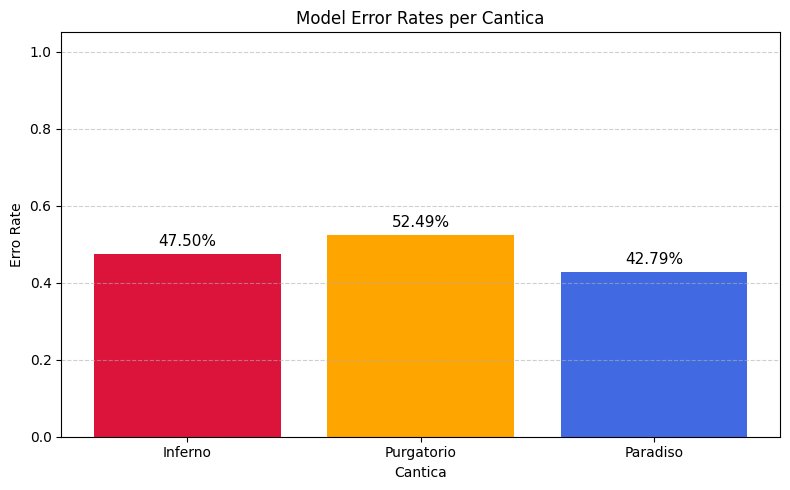

In [127]:
import matplotlib.pyplot as plt

labels = list(canticaLabels.values())
colors = ['crimson', 'orange', 'royalblue']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, Model1_err, color=colors)

plt.title("Model Error Rates per Cantica")
plt.xlabel("Cantica")
plt.ylabel("Erro Rate")
plt.ylim(0, 1.05)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2%}", ha='center', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Model1_error_rates.png", dpi=300) #save the figure with a resolution of 300 dpi
plt.show()

## Model #2
We can now introduce another model, slightly similar to the first one. Here the focus is related to the **occurrencies of each word**. In this case we have $M$ random variables $Y_j \in \mathbb{N}$ which describe how many times each token $x_i$ (which in the previous model was considered a random variblae but here it's not) compares in the text to analyze. So we can formalize all of this this way: <br>
Let the document be represented by a sequence of tokens:

$$
x = [x_1, x_2, \dots, x_N]
$$

We define $M$ random variables $Y_1, Y_2, \dots, Y_M$ where each $Y_j \in \mathbb{N}$ denotes the number of occurrences of word $j$ in the document.

The relation between the previous model (with $X_i$) and the new model is:

$$
Y_j = \sum_{i=1}^{N} \mathbb{I}[X_i = j]
$$

where $\mathbb{I}[X_i = j]$ is the indicator function, equal to 1 if the $i$-th word is $j$, and 0 otherwise. <br>
So, for example: <br>
Let  
$$
x = [x_1, x_2, \dots, x_6] = [\text{love}, \text{hope}, \text{love}, \text{peace}, \text{hope}, \text{hope}]
$$

Then we can define these random variables:
$$
Y_{\text{love}} = \sum_{i=1}^6 \mathbb{I}[x_i = \text{love}] = 2
$$

$$
Y_{\text{peace}} = \sum_{i=1}^6 \mathbb{I}[x_i = \text{peace}] = 1
$$

$$
Y_{\text{hope}} = \sum_{i=1}^6 \mathbb{I}[x_i = \text{hope}] = 3
$$
This rapresentation is often called **Bag of Words** (*BoW*). We assume a **Multinomial distribution** for our new random variables, because we consider each word occurrence to be an **independet draw** from the **categorical distribution** over the vocabulary of words, and then we count how many times the words occurr in the document, so we can formalize everything this way:
$$
(Y_1, Y_2, ..., Y_M) \sim \text{Multinomial}(N, \Pi)
$$
Where:
- $N = \sum_{j=1}^{M} Y_j$ is the total number of tokens of the text, computed summing all the occurrencies of each word together
- $\Pi = \left[ \pi_{c, 1}, \pi_{c, 2}, ..., \pi_{c, M}\right]$ are the class-conditional probabilities of each word given class $c$, so they're again the model parameters.

Now, we can calculate the likelihood by recalling the formula for the Multinomial density:
$$
\mathcal{L}_Y(\mathbf{\Pi}) = \frac{N!}{y_1! \dots y_M!} \prod_{j=1}^{m} \pi_j^{y_j} = \frac{N!}{N_1! \dots N_M!} \prod_{j=1}^{m} \pi_j^{N_j}
$$

since $y_j$ is the number of occurrences of word $j$, i.e. $y_j = N_j$. The log-likelihood is thus

$$
\ell_Y(\mathbf{\Pi}) = \log \mathcal{L}_Y(\mathbf{\Pi}) = \xi + \sum_{j=1}^{m} y_j \log \pi_j = \xi + \sum_{j=1}^{m} N_j \log \pi_j
$$

where the term $\xi$ is the logarithm of the multinomial coefficients, which is constant with respect to the model parameters $\Pi = \left[ \pi_{c, 1}, \pi_{c, 2}, ..., \pi_{c, M}\right]$, so we don't consider it when maximizing the log-likelihood. <br>
Apart from the constant, **this is exactly equal to the log-likelihood of the first model!**
So we can write:
$$
\mathcal{L}_X(\mathbf{\Pi}) \propto \mathcal{L}_Y(\mathbf{\Pi}) \\
\ell_X(\mathbf{\Pi}) \propto \ell_Y(\mathbf{\Pi})
$$
Since the likelihoods are proportional, **inference** will be the same using te Maximum Likelihood Approach (because we are trying to mazimize two proportional functions):
- ML estimates will be the same for both models (the terms $\xi$ is irrelevant for maximization)
- Likelihood ratios and class posterior probabilities will also be the same, since the proportionality term $\alpha = e^{\xi}$ simplifies

In conclusion, **from an implementation point of view, the computational steps of the second model are the same as the first one. The only difference is that we work with word counts instead of word sequences.** <br>
The results, obviously, will be **the same**.